<a href="https://colab.research.google.com/github/balwanthr/house-price-prediction/blob/main/House_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TASK 1


HOUSE PRICE PREDICTION

This House Price Prediction system harnesses the power of artificial intelligence, machine learning algorithms, and vast datasets to unravel the complexities underlying property valuation. By leveraging historical sales data, demographic trends, economic indicators, and a myriad of other relevant factors, our system transcends traditional methodologies, offering a forward-looking perspective that adapts to the ever-changing dynamics of the real estate landscape.



In [1]:
import pandas as pd
from tqdm.notebook import tqdm

def read_all_sheets_from_excel(path: str) -> dict:
    all_sheets = pd.read_excel(path, sheet_name=None)
    for name, df in tqdm(all_sheets.items(), desc='Loading sheets'):
        df.columns = [c.strip() if isinstance(c, str) else c for c in df.columns]
        df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)
        all_sheets[name] = df
    return all_sheets

# Load the data
file_path = 'HousePricePrediction.xlsx'
dataframes = read_all_sheets_from_excel(file_path)

# Print each dataframe name and head
for sheet_name, df in dataframes.items():
    print(f'Head for {sheet_name}:')
    print(df.head())

Loading sheets:   0%|          | 0/1 [00:00<?, ?it/s]

Head for Sheet1:
   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  


The head of the dataframe from 'Sheet1' shows a selection of features that could be relevant for predicting house prices, such as 'MSSubClass', 'MSZoning', 'LotArea', and others, including the target variable 'SalePrice'.

Next, I will plot some distributions for the numerical columns to understand the data better. This will include histograms for features like 'LotArea', 'YearBuilt', 'TotalBsmtSF', and the target 'SalePrice'. Let's proceed with that.


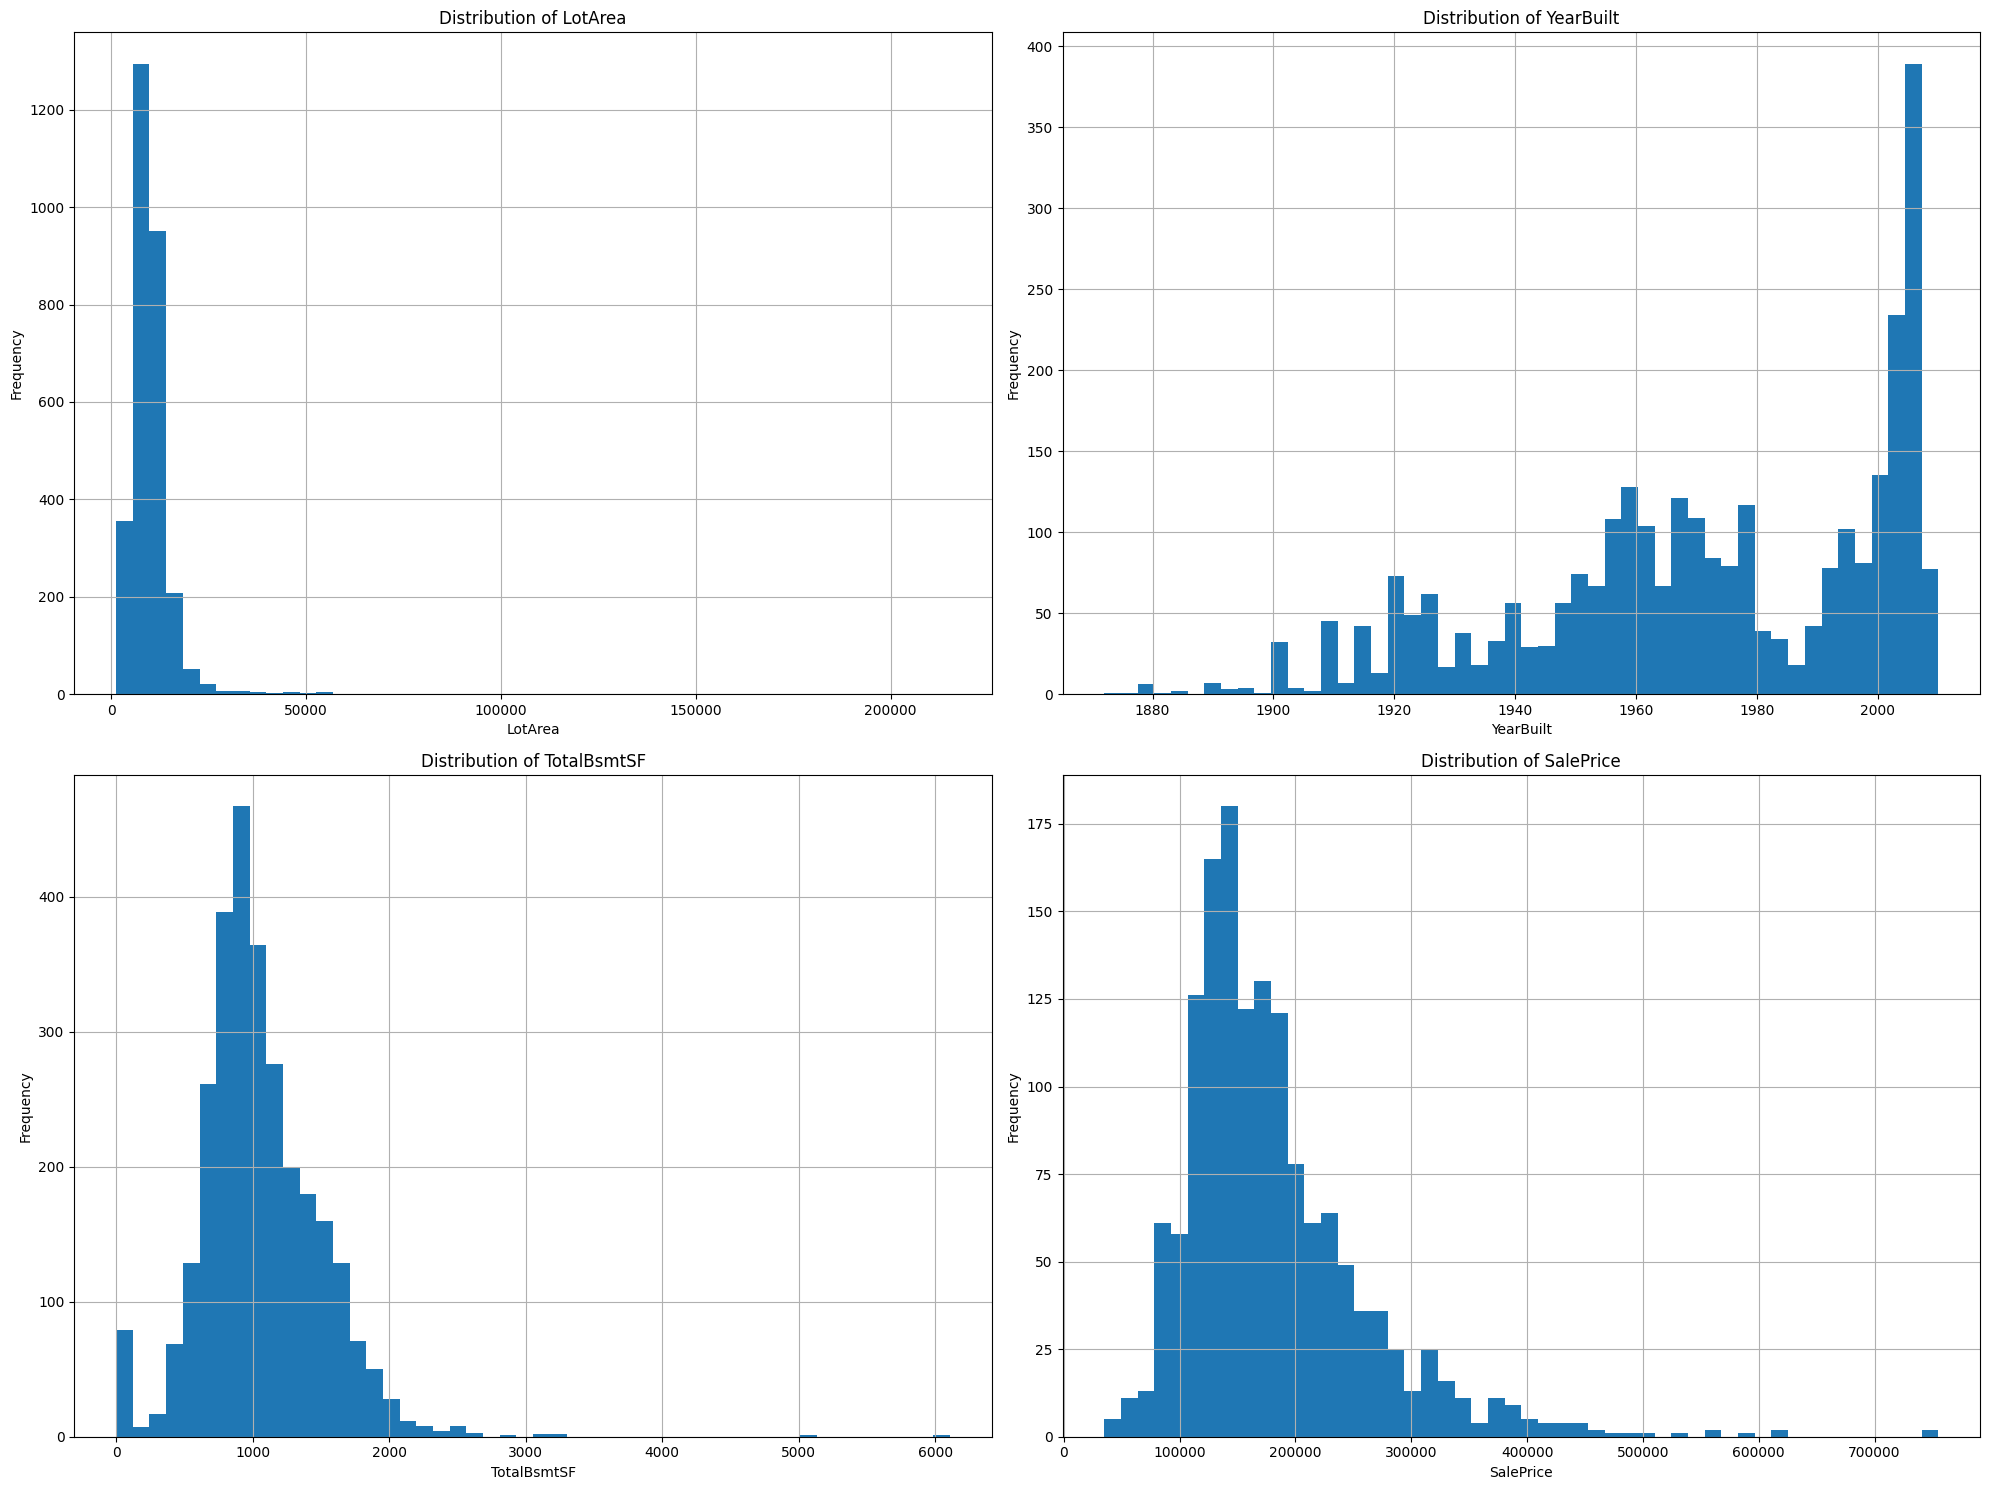

In [2]:
import matplotlib.pyplot as plt

# Selecting numerical columns for distribution plots
numerical_columns = ['LotArea', 'YearBuilt', 'TotalBsmtSF', 'SalePrice']
df = dataframes['Sheet1'][numerical_columns]

# Plotting distributions using histograms
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    df[col].hist(bins=50)
    plt.title('Distribution of ' + col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

These histograms provide a visual summary of the distributions of each numerical feature, which is essential for understanding the range and common values for each feature in the dataset.

Now, I will proceed to check for any missing values in the dataset, which is a crucial step before applying any machine learning model.

In [3]:
# Checking for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print('Missing values in each column:')
print(missing_values)

Missing values in each column:
TotalBsmtSF       1
SalePrice      1459
dtype: int64


There are missing values in the 'TotalBsmtSF' and 'SalePrice' columns. Specifically, 'TotalBsmtSF' has 1 missing value, and 'SalePrice' has 1459 missing values, which is quite significant.

Before proceeding with the Support Vector Machine (SVM) model, we need to address these missing values. Here are a couple of options:

For 'TotalBsmtSF', since there is only one missing value, we could fill it with the median or mean of the column.
For 'SalePrice', the large number of missing values suggests that this might be a split between training and test sets. If 'SalePrice' is the target variable, we would not fill these values but ensure that the model is trained only on the non-missing values.

In [4]:
# Fill the single missing 'TotalBsmtSF' value with the median
median_total_bsmt_sf = df['TotalBsmtSF'].median()
df['TotalBsmtSF'].fillna(median_total_bsmt_sf, inplace=True)

# Confirm the missing value has been filled
missing_values_after_filling = df.isnull().sum()
missing_values_after_filling = missing_values_after_filling[missing_values_after_filling > 0]
print('Missing values after filling TotalBsmtSF:')
print(missing_values_after_filling)

# Separating the dataset into training and test sets based on 'SalePrice' missing values
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

# Display the shapes of the train and test sets
print('Training set shape:', train_df.shape)
print('Test set shape:', test_df.shape)

Missing values after filling TotalBsmtSF:
SalePrice    1459
dtype: int64
Training set shape: (1460, 4)
Test set shape: (1459, 4)


<ipython-input-4-f77a64e195fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalBsmtSF'].fillna(median_total_bsmt_sf, inplace=True)


Prepare the dataset for a machine learning model by handling missing values in the 'TotalBsmtSF' column, separating the data into training and test sets based on the availability of the 'SalePrice' values, and checking for any remaining missing values in the dataset. The filling of the missing 'TotalBsmtSF' value with the median ensures that the dataset is ready for further analysis and modeling.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt

# Preparing the feature matrix and target vector
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

# Splitting the training set for model validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating an SVM model with a pipeline that includes scaling
svm_pipeline = make_pipeline(StandardScaler(), SVR(kernel='linear'))

# Training the model
svm_pipeline.fit(X_train, y_train)

# Predicting on the validation set
y_pred = svm_pipeline.predict(X_val)

# Calculating RMSE for the validation predictions
rmse = sqrt(mean_squared_error(y_val, y_pred))
print('RMSE on validation set:', rmse)

RMSE on validation set: 87986.80442790122


This code is implementing a simple interactive front-end interface using the ipywidgets library in Python, allowing users to input values for three features—'LotArea,' 'YearBuilt,' and 'TotalBsmtSF'—and receive a predicted house price based on a pre-trained Support Vector Machine (SVM) regression model.

In [23]:
import warnings
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interactive

# Suppress the warning about feature names in StandardScaler
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Create input widgets for the house features
lotarea_widget = widgets.IntSlider(value=8450, min=1300, max=215245, step=100, description='LotArea')
yearbuilt_widget = widgets.IntSlider(value=2003, min=1872, max=2010, step=1, description='YearBuilt')
totalbsmtsf_widget = widgets.IntSlider(value=856, min=0, max=6110, step=100, description='TotalBsmtSF')

# Output widget for displaying the prediction
output_box = widgets.Output()

# Heading Widget
heading = widgets.HTML("<h1>Predict the House Price</h1>")

# Define the function to predict house price based on input features
def predict_house_price(LotArea, YearBuilt, TotalBsmtSF):
    input_features = [[LotArea, YearBuilt, TotalBsmtSF]]

    # Suppress the warning about feature names in StandardScaler
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)

        # Scaling the input features
        input_features_scaled = svm_pipeline.named_steps['standardscaler'].transform(input_features)

    # Predicting the house price
    predicted_price = svm_pipeline.named_steps['svr'].predict(input_features_scaled)

    # Display the prediction in the output box with bold and larger font
    with output_box:
        output_box.clear_output(wait=True)
        display(HTML(f'<span style="font-weight:bold; font-size:20px;">Predicted House Price: {predicted_price[0]:.2f}</span>'))

# Create an interactive widget using the interactive function
interactive_widget = interactive(predict_house_price, LotArea=lotarea_widget, YearBuilt=yearbuilt_widget, TotalBsmtSF=totalbsmtsf_widget)

# Combine all widgets into a single layout
full_layout = widgets.VBox([heading, interactive_widget, output_box])

# Display the layout
display(full_layout)
